# Travel Insurance Case
### Created by : Andre Setiawan

## Business Problem Understanding

**Konteks :**

Travel insurance adalah produk asuransi yang memberikan perlindungan kepada penumpang selama perjalanan domestik maupun internasional. Perlindungan ini meliputi pembatalan penerbangan, keterlambatan keberangkatan, kehilangan atau kerusakan bagasi, kecelakaan, hingga biaya perawatan medis selama perjalanan.
Secara umum, travel insurance bersifat opsional dan dapat ditambahkan saat pemesanan tiket. Tidak semua penumpang mengajukan klaim, karena klaim hanya berlaku jika terjadi kejadian yang sesuai dengan ketentuan polis.

Target atau Output (y) :
- 0 : tidak melakukan claim
- 1 : melakukan claim

**Problem :**

Meskipun travel insurance menjadi sumber pendapatan tambahan, perusahaan juga menghadapi risiko kerugian ketika jumlah dan nilai klaim yang diajukan melebihi pendapatan dari penjualannya.
Saat ini perusahaan kesulitan mengidentifikasi penumpang yang memiliki potensi tinggi untuk mengajukan klaim. Tanpa analisis risiko yang tepat, perusahaan bisa mengalami:
- kerugian finansial,
- salah sasaran dalam pemberian penawaran produk,
- pricing yang tidak optimal


**Goal :**

Perusahaan ingin membangun model machine learning untuk:
- Memprediksi kemungkinan seorang penumpang akan mengajukan klaim.
- Mengidentifikasi faktor-faktor penting yang berkontribusi terhadap risiko klaim, sehingga dapat mendukung pengambilan keputusan seperti penyesuaian harga dan strategi penjualan.

**Analytic Approach :**

Pendekatan analitik yang akan dilakukan:
- Melakukan eksplorasi data untuk menemukan pola dan faktor yang mempengaruhi klaim.
- Membangun model machine learning (misalnya: logistic regression, random forest) untuk memprediksi probabilitas klaim seorang penumpang.
- Mengevaluasi performa model menggunakan metrik klasifikasi (precision, recall, F1-score).

In [1]:
# Library
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Handling Imbalance
from imblearn.over_sampling import SMOTE

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
# Load dataset
df = pd.read_csv("data_travel_insurance.csv")
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


## Data Description
- Agency : Kode travel agency yang menjual produk asuransi perjalanan.
- Agency Type : Jenis agency terdiri dari airlines (perusahaan penerbangan) dan travel agency (agensi travel).
- Distribution Channel : Channel dimana produk travel insurance dijual, terdiri dari online dan offline.
- Product Name : Jenis produk travel insurance yang dijual.
- Gender : Jenis kelamin penumpang, terdiri dari male, female dan NaN (tidak terisi informasinya).
- Duration : Durasi polis dalam satuan hari.
- Destination : Negara tujuan perjalanan.
- Net Sales : Jumlah pendapatan bersih dari jenis produk travel insurance yang dijual.
- Commision (in value) : Komisi yang diberikan jika produk travel insurance berhasil terjual.
- Age : Umur penumpang
- Claim : Keterangan apakah penumpang melakukan claim travel insurance atau tidak

## Checking Missing Value

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [4]:
list_data = []
for col in df.columns:
    list_data.append([
        col,
        df[col].dtype,
        df[col].isna().sum(),
        round((df[col].isna().sum() / len(df[col])) * 100, 2),
        df[col].nunique(),
        list(df[col].drop_duplicates().sample(2).values)
    ])
df_desc = pd.DataFrame(
    columns=["data_features", "data_type", "null", "null_prct", "unique", "unique_samples"],
    data=list_data
)
df_desc

,data_features,data_type,null,null_prct,unique,unique_samples
0,Agency,object,0,0.00,16,"[LWC, EPX]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Child Comprehensive Plan, Annual Travel Prote..."
4,Gender,object,31647,71.39,2,"[F, nan]"
5,Duration,int64,0,0.00,437,"[351, 229]"
6,Destination,object,0,0.00,138,"[CHILE, JAPAN]"
7,Net Sales,float64,0,0.00,1006,"[50.25, -19.0]"
8,Commision (in value),float64,0,0.00,915,"[22.25, 16.0]"
9,Age,int64,0,0.00,89,"[70, 75]"


In [5]:
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

Dari data description di atas diketahui bahwa kolom gender memiliki banyak nilai null (missing value) yaitu 31.647 dari total 44.328 data yang berarti 71.39% data bernilai null. Untuk data yang bernilai null sebenarnya dapat diisi dengan nilai Unknown namun hal ini tidak memberikan informasi yang berarti bagi model machine learning. Selain itu, faktor Gender berpotensi menjadi variabel diskriminatif jika digunakan sebagai fitur (X) dalam penentuan klaim asuransi perjalanan. Oleh karena itu, sebaiknya kolom Gender dihapus dari dataset.

In [6]:
df = df.drop(columns=["Gender"])
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No


## Checking Duplicate Data

In [7]:
duplicate_data = df.duplicated().sum()
print("Jumlah duplikat data :", duplicate_data) 
df[df.duplicated(keep=False)].head()

Jumlah duplikat data : 5004


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
5,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
31,EPX,Travel Agency,Online,Cancellation Plan,19,UNITED KINGDOM,10.0,0.0,36,No


Jika kita lihat data di atas, diketahui bahwa dataset Travel Insurance memiliki data duplikasi sebanyak 5004 data. Sebelum melakukan training model machine learning, duplikat data ini harus dibuang agar tidak mengganggu proses learning.

In [8]:
df = df.drop_duplicates()
df = df.copy()

## Checking Outliers

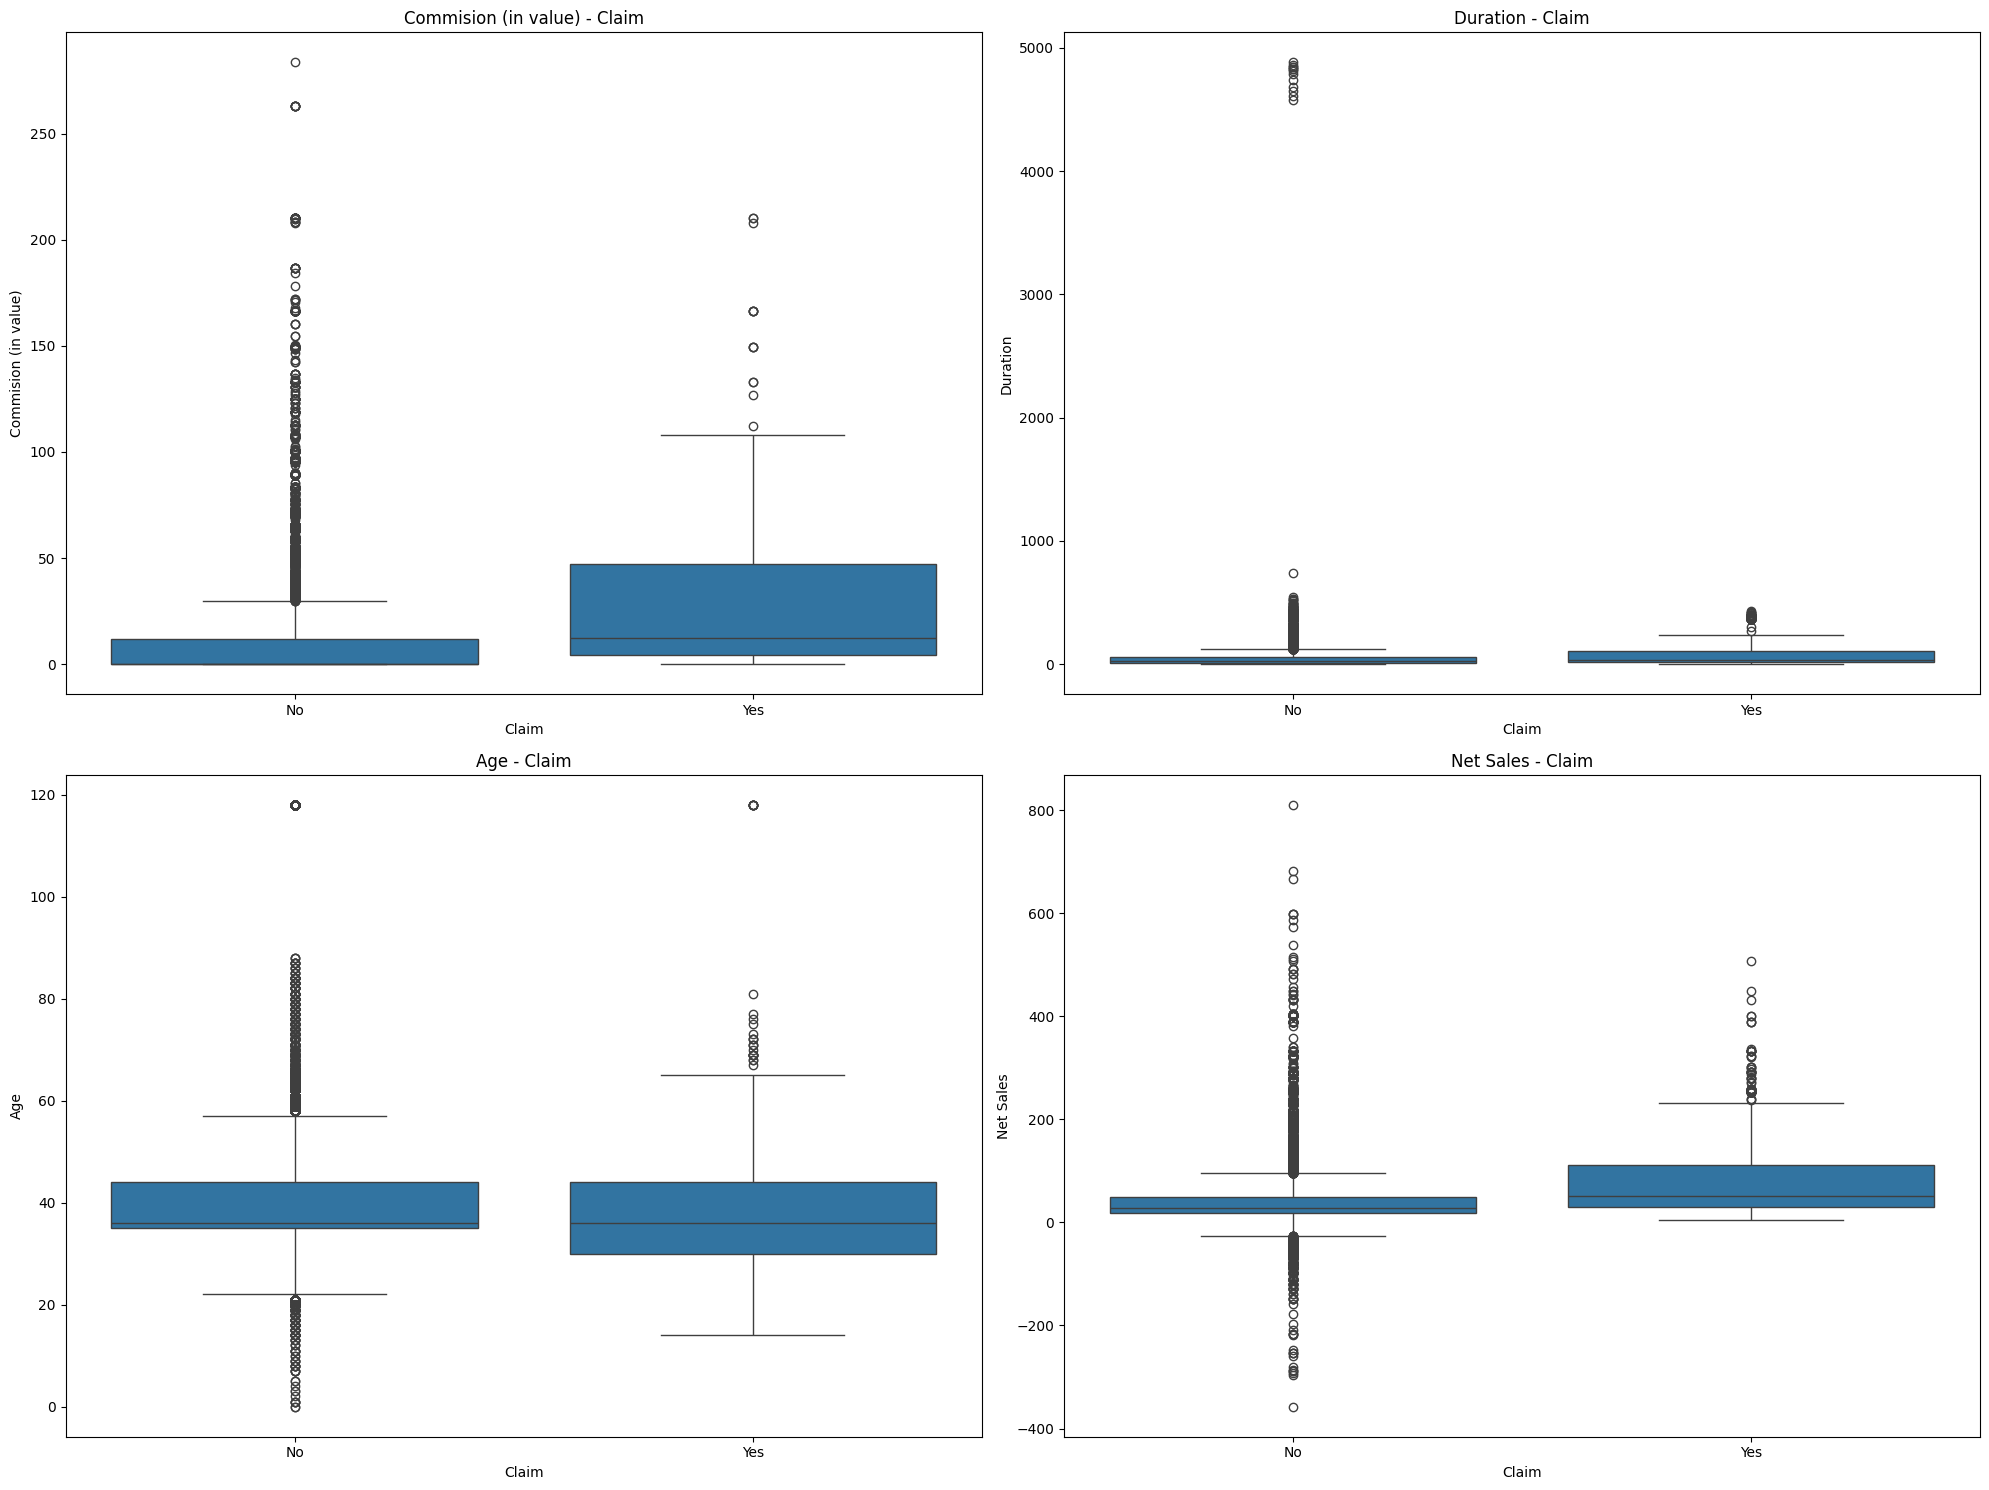

In [9]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
sns.boxplot(data=df, x="Claim", y ="Commision (in value)")
plt.title("Commision (in value) - Claim")
plt.subplot(2,2,2)
sns.boxplot(data=df, x="Claim", y ="Duration")
plt.title("Duration - Claim")
plt.subplot(2,2,3)
sns.boxplot(data=df, x="Claim", y ="Age")
plt.title("Age - Claim")
plt.subplot(2,2,4)
sns.boxplot(data=df, x="Claim", y ="Net Sales")
plt.title("Net Sales - Claim")
plt.tight_layout()
plt.show()

Selain adanya missing value dan duplicate data, ternyata dataset Travel Insurance juga memiliki banyak outlier. Outlier ini juga bisa mengganggu proses learning model. Outlier pada data tidak akan dihapus, namun ditangani dengan metode IQR Capping dan Log transform dengan tujuan untuk menyesuaikan nilai ekstrem agar berada dalam batas yang wajar. Pendekatan ini menjaga distribusi data tetap stabil tanpa kehilangan informasi penting.

## Correlation Matrix

Dataset Travel Insurance memiliki beberapa kolom di antaranya adalah Agency, Agency Type, Distribution Channel, Product Name, Duration, Destination, Net Sales, Commision (in value) dan Age. Sedangkan kolom Claim merupakan target yang akan diprediksi oleh model machine learning. Untuk mengetahui korelasi antara kolom yang ada dengan target Claim = Yes, kita dapat menggunakan correlation matrix khususnya untuk kolom numerik. Berikut ini adalah correlation matrix kolom Duration, Net Sales, Commision (in value) dan Age.

In [10]:
num_df = df.select_dtypes(include=["int64", "float64"])
corr_matrix = num_df.corr()
corr_matrix

,Duration,Net Sales,Commision (in value),Age
Duration,1.000000,0.366482,0.295394,0.012637
Net Sales,0.366482,1.000000,0.636338,0.040453
Commision (in value),0.295394,0.636338,1.000000,0.116376
Age,0.012637,0.040453,0.116376,1.000000


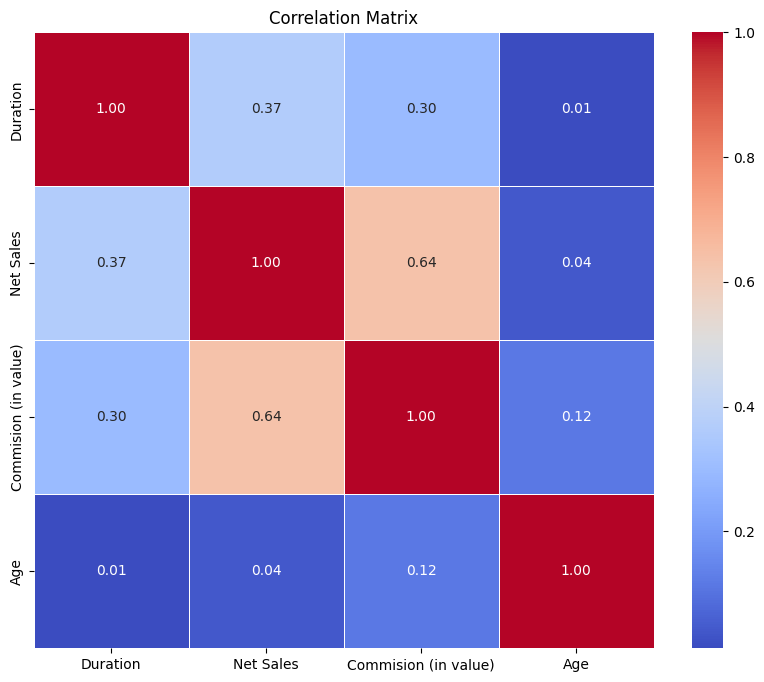

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Dari correlation matrix di atas diketahui bahwa sebagian besar fitur numerik memiliki hubungan yang lemah hingga sedang. Hubungan paling kuat terlihat pada net sales dengan commision (in value) yang saling berkaitan secara bisnis. Tidak ada korelasi yang terlalu tinggi sehingga seluruh fitur numerik tetap digunakan dalam model.

## Bar Plot Claim Rate

In [12]:
df["Claim"] = df["Claim"].map({"No":0, "Yes":1})

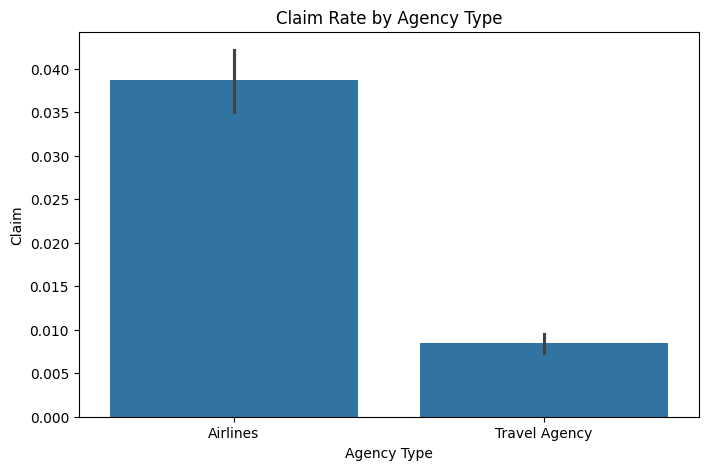

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Agency Type", y="Claim", estimator=np.mean)
plt.title("Claim Rate by Agency Type")
plt.xlabel("Agency Type")
plt.ylabel("Claim")
plt.show()

Berdasarkan bar plot Claim Rate by Agency Type dapat dilihat bahwa polis yang dibeli melalui Airlines memiliki tingkat claim yang lebih tinggi dibandingkan dengan polis yang dibeli melalui Travel Agency.

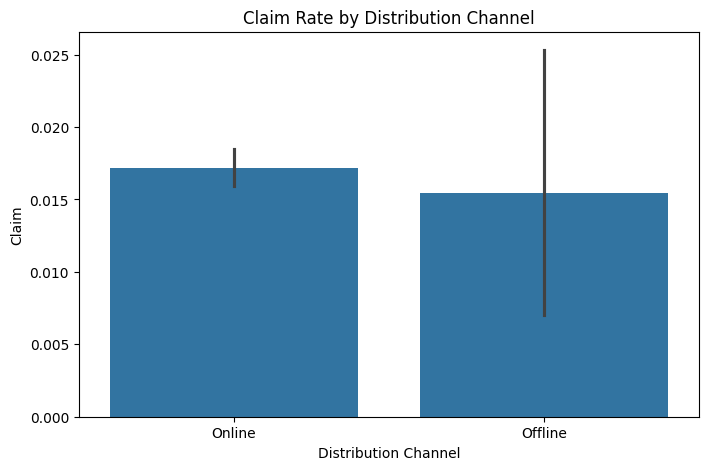

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Distribution Channel", y="Claim", estimator=np.mean)
plt.title("Claim Rate by Distribution Channel")
plt.xlabel("Distribution Channel")
plt.ylabel("Claim")
plt.show()

Berdasarkan bar plot Claim Rate by Distribution Channel dapat dilihat bahwa polis yang dibeli secara online lebih sering dilakukan claim dibandingkan polis yang dibeli secara offline walaupun tidak terlalu signifikan perbedaannya. 

## Negative Value & Log Transform

In [15]:
df[["Duration", "Net Sales", "Commision (in value)", "Age"]].describe()

,Duration,Net Sales,Commision (in value),Age
count,39324.000000,39324.00000,39324.000000,39324.000000
mean,52.275989,42.20253,10.386189,39.833054
std,113.404932,49.70403,20.345275,13.225494
min,-1.000000,-357.50000,0.000000,0.000000
25%,11.000000,19.00000,0.000000,35.000000
50%,25.000000,29.00000,0.000000,36.000000
75%,57.000000,50.00000,11.880000,44.000000
max,4881.000000,810.00000,283.500000,118.000000


Jika dilihat dari deskripsi dataset numerikal di atas, ditemukan beberapa nilai yang berada di luar rentang yang umum. Sebagai contoh, pada variabel Net Sales terdapat nilai minimum di bawah nol sedangkan pada variabel Commision (in value) distribusi data didominasi oleh nilai nol. Untuk variabel Age juga terdapat nilai min sebesar 0 tahun (bayi?) dan nilai max sebesar 118 tahun yang mana secara logika umur manusia tersebut tidak memungkinkan untuk melakukan perjalanan jauh. Oleh karena itu kita dapat memperbaiki data dengan cara mengubah negative value dan melakukan log transform. Distribusi data yang kita lihat sebagai outlier pada diagram plot di atas juga diperbaiki dengan menggunakan metode IQR Capping (Winsorizing) untuk mengurangi data outlier.

In [16]:
for col in ["Net Sales", "Commision (in value)"]:
    df[col] = df[col].apply(lambda x: max(x, 0))
    df[col] = np.log1p(df[col])

## IQR Capping (Winsorizing)

In [17]:
numerical_cols = ["Duration", "Net Sales", "Commision (in value)", "Age"]
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


In [18]:
outliers_after = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_after[col] = int(((df[col] < lower_bound) | (df[col] > upper_bound)).sum())

print("Jumlah outlier setelah capping:", outliers_after)

Jumlah outlier setelah capping: {'Duration': 0, 'Net Sales': 0, 'Commision (in value)': 0, 'Age': 0}


## Grouping Destination Based On Area

Jika kita perhatikan deskripsi dataset travel insurance di atas, kolom Destination yang merupakan data objek memiliki data unik yang cukup banyak, yaitu sebanyak 138 data. Jika data ini dibuat menjadi numerik dengan menggunakan one hot encoding, kolom Destination ini akan menimbulkan sparse matrix dan dapat mempengaruhi performansi model pada saat learning. Oleh karena itu sebaiknya kita kategorikan Destination berdasarkan wilayah agar variasi data uniknya berkurang.

In [19]:
unique_destinations = df["Destination"].unique()
print(unique_destinations)

['SINGAPORE' 'MALAYSIA' 'INDIA' 'UNITED STATES' 'KOREA, REPUBLIC OF'
 'THAILAND' 'GERMANY' 'JAPAN' 'INDONESIA' 'VIET NAM' 'AUSTRALIA' 'FINLAND'
 'UNITED KINGDOM' 'SRI LANKA' 'SPAIN' 'HONG KONG' 'MACAO' 'CHINA'
 'UNITED ARAB EMIRATES' 'IRAN, ISLAMIC REPUBLIC OF'
 'TAIWAN, PROVINCE OF CHINA' 'POLAND' 'CANADA' 'OMAN' 'PHILIPPINES'
 'GREECE' 'BELGIUM' 'TURKEY' 'BRUNEI DARUSSALAM' 'DENMARK' 'SWITZERLAND'
 'NETHERLANDS' 'SWEDEN' 'MYANMAR' 'KENYA' 'CZECH REPUBLIC' 'FRANCE'
 'RUSSIAN FEDERATION' 'PAKISTAN' 'ARGENTINA'
 'TANZANIA, UNITED REPUBLIC OF' 'SERBIA' 'ITALY' 'CROATIA' 'NEW ZEALAND'
 'PERU' 'MONGOLIA' 'CAMBODIA' 'QATAR' 'NORWAY' 'LUXEMBOURG' 'MALTA'
 "LAO PEOPLE'S DEMOCRATIC REPUBLIC" 'ISRAEL' 'SAUDI ARABIA' 'AUSTRIA'
 'PORTUGAL' 'NEPAL' 'UKRAINE' 'ESTONIA' 'ICELAND' 'BRAZIL' 'MEXICO'
 'CAYMAN ISLANDS' 'PANAMA' 'BANGLADESH' 'TURKMENISTAN' 'BAHRAIN'
 'KAZAKHSTAN' 'TUNISIA' 'IRELAND' 'ETHIOPIA' 'NORTHERN MARIANA ISLANDS'
 'MALDIVES' 'SOUTH AFRICA' 'VENEZUELA' 'COSTA RICA' 'JORDAN' 'MALI'


In [20]:
asia = [
    "SINGAPORE","MALAYSIA","INDIA","KOREA, REPUBLIC OF","THAILAND","JAPAN",
    "INDONESIA","VIET NAM","SRI LANKA","HONG KONG","MACAO","CHINA",
    "IRAN, ISLAMIC REPUBLIC OF","TAIWAN, PROVINCE OF CHINA","OMAN",
    "PHILIPPINES","BRUNEI DARUSSALAM","MYANMAR","PAKISTAN","MONGOLIA",
    "CAMBODIA","QATAR","SAUDI ARABIA","NEPAL","AZERBAIJAN","BHUTAN",
    "UZBEKISTAN","MALDIVES","JORDAN","CYPRUS","KUWAIT","KAZAKHSTAN",
    "ARMENIA","TAJIKISTAN","KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"
]

europe = [
    "GERMANY","FINLAND","UNITED KINGDOM","SPAIN","POLAND","GREECE","BELGIUM",
    "DENMARK","SWITZERLAND","NETHERLANDS","SWEDEN","CZECH REPUBLIC","FRANCE",
    "SERBIA","ITALY","CROATIA","NORWAY","LUXEMBOURG","MALTA","ESTONIA",
    "ICELAND","PORTUGAL","UKRAINE","HUNGARY","BELARUS","SLOVENIA",
    "BULGARIA","LATVIA","ROMANIA","LITHUANIA","FAROE ISLANDS",
    "MOLDOVA, REPUBLIC OF","IRELAND","MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF",
    "REPUBLIC OF MONTENEGRO"
]

africa = [
    "KENYA","TANZANIA, UNITED REPUBLIC OF","ANGOLA","NIGERIA","NAMIBIA",
    "EGYPT","ZIMBABWE","GHANA","MALI","TUNISIA","ETHIOPIA","MAURITIUS",
    "SENEGAL","CAMEROON","ZAMBIA","RWANDA","BOTSWANA","GUINEA",
    "GUINEA-BISSAU","BENIN","REUNION"
]

americas = [
    "UNITED STATES","CANADA","ARGENTINA","PERU","BRAZIL","MEXICO",
    "CAYMAN ISLANDS","PANAMA","COLOMBIA","URUGUAY","VENEZUELA",
    "COSTA RICA","PUERTO RICO","CHILE","BOLIVIA","TRINIDAD AND TOBAGO",
    "JAMAICA","GUYANA","DOMINICAN REPUBLIC"
]

oceania = [
    "AUSTRALIA","NEW ZEALAND","FIJI","VANUATU","SAMOA","GUAM",
    "NORTHERN MARIANA ISLANDS","FRENCH POLYNESIA","PAPUA NEW GUINEA"
]

In [21]:
continent_map = {}
for country in asia:
    continent_map[country] = "Asia"
for country in europe:
    continent_map[country] = "Europe"
for country in africa:
    continent_map[country] = "Africa"
for country in americas:
    continent_map[country] = "Americas"
for country in oceania:
    continent_map[country] = "Oceania"

df["Destination Area"] = df["Destination"].map(continent_map)

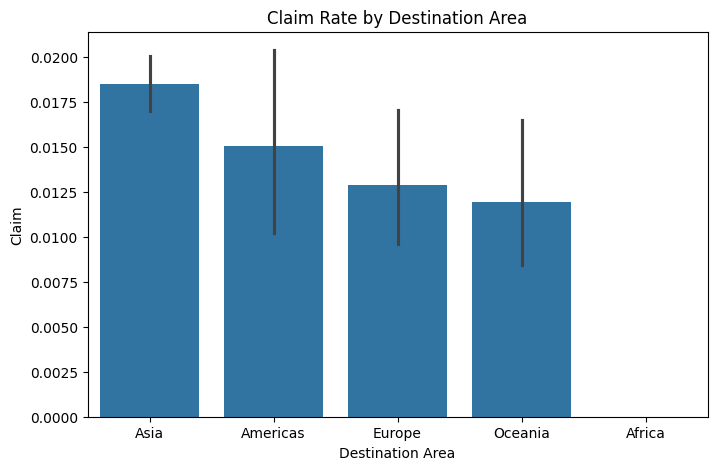

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Destination Area", y="Claim", estimator=np.mean)
plt.title("Claim Rate by Destination Area")
plt.xlabel("Destination Area")
plt.ylabel("Claim")
plt.show()

Berdasarkan bar plot Claim Rate by Destination Area dapat dilihat bahwa perjalanan ke negara di Asia memiliki tingkat claim yang paling tinggi diikuti negara America, Eropa dan Oceania, sedangkan negara Africa menjadi negara tujuan yang tidak memiliki tingkat claim sama sekali.

## Train - Test Data Split

Setelah data cleaning selesai dilakukan, kita dapat mulai membagi dataset menjadi 2 bagian, yaitu data training dan data testing untuk membuat model machine learning. Kita pisahkan variabel input (x) dan variabel output (y sebagai target).

In [23]:
x = df.drop("Claim", axis=1)
y = df["Claim"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) 

## Encoding

Selanjutnya sebelum dilakukan proses training, variabel input yang masih memiliki data kategorikal perlu diubah menjadi data numerikal dengan menggunakan metode Encoding. Jadi data yang akan diproses encoding antara lain adalah kolom Agency, Agency Type, Distribution Channel, Product Name dan Destination.

In [24]:
categorical_cols = x_train.select_dtypes(include="object").columns
numeric_cols = x_train.select_dtypes(exclude="object").columns
preprocessor = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"),categorical_cols),("num", "passthrough", numerical_cols)])
x_train_enc = preprocessor.fit_transform(x_train)
x_test_enc = preprocessor.transform(x_test)

## Resampling SMOTE to fix Imbalance Dataset

In [25]:
df["Claim"].value_counts()

Claim
0    38651
1      673
Name: count, dtype: int64

Jika melihat nilai kolom Claim, dapat dilihat bahwa nilai 0 (Claim = No) lebih mendominasi dari pada nilai 1 (Claim = Yes). Padahal tujuan dari model machine learning adalah untuk memprediksi kemungkinan Claim = Yes. Dapat disimpulkan bahwa dataset ini merupakan dataset yang imbalance dan berpotensi menyebabkan model cenderung memprediksi kelas mayoritas. Untuk mengatasi masalah ini dapat dilakukan teknik resampling untuk meningkatkan representasi kelas minoritas sebelum proses pemodelan. Teknik resampling yang saya gunakan adalah SMOTE (Synthetic Minority Over-Sampling Technique) yang akan menyeimbangkan distribusi kelas dengan cara membuat data sintesis pada kelas minoritas (Claim = Yes) pada data training (data testing tidak perlu resampling SMOTE) sehingga membantu model belajar pola klaim dengan lebih baik tanpa menghapus data asli.

In [26]:
sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_resample(x_train_enc, y_train)

## Model Selection

Untuk pemilihan model machine learning yang saya gunakan adalah Random Forest dimana model ini mampu menangani data dengan variable yang kompleks dengan hubungan non-linear, tidak sensitif terhadap outlier dan dapat bekerja dengan baik pada dataset yang imbalance.

In [27]:
model = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_split=100, min_samples_leaf=50, class_weight="balanced", random_state=42)
model.fit(x_train_sm, y_train_sm)

,n_estimators,400
,criterion,'gini'
,max_depth,10
,min_samples_split,100
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Threshold Tuning

Selain melakukan teknik resampling SMOTE, salah satu cara untuk mengatasi permasalahan model tidak bisa memprediksi kelas minoritas pada dataset imbalance adalah dengan melakukan threshold tuning. Threshold (ambang batas) dalam machine learning adalah nilai batas yang digunakan untuk menentukan hasil akhir prediksi kelas berdasarkan nilai probabilitas yang dihasilkan oleh model. Pada umumnya nilai threshold default adalah 0.5 dimana pada kasus dataset imbalance seringkali tidak optimal untuk mendeteksi kelas minoritas yang menjadi fokus prediksi.

In [28]:
y_prob = model.predict_proba(x_test_enc)[:, 1]

best_threshold = 0
best_recall = 0
best_precision = 0
best_f1 = 0

for t in np.arange(0.10, 0.40, 0.01):
    y_pred_t = (y_prob >= t).astype(int)
    rec_t = recall_score(y_test, y_pred_t, pos_label=1)
    prec_t = precision_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    f1_t = f1_score(y_test, y_pred_t, pos_label=1)
    
    if rec_t > best_recall:
        best_threshold = t
        best_recall = rec_t
        best_precision = prec_t
        best_f1 = f1_t

print("Best Threshold Result For Maximizing Recall")
print(f"Threshold : {best_threshold:.2f}")
print(f"Recall (kelas 1) : {best_recall:.4f}")
print(f"Precision (kelas 1) : {best_precision:.4f}")
print(f"F1 Score (kelas 1) : {best_f1:.4f}")

y_pred_best = (y_prob >= best_threshold).astype(int)

print("Classification Report Dengan Threshold Terbaik")
print(classification_report(y_test, y_pred_best, digits=4))

Best Threshold Result For Maximizing Recall
Threshold : 0.10
Recall (kelas 1) : 0.9407
Precision (kelas 1) : 0.0243
F1 Score (kelas 1) : 0.0474
Classification Report Dengan Threshold Terbaik
              precision    recall  f1-score   support

           0     0.9970    0.3411    0.5083      7730
           1     0.0243    0.9407    0.0474       135

    accuracy                         0.3514      7865
   macro avg     0.5107    0.6409    0.2779      7865
weighted avg     0.9803    0.3514    0.5004      7865



Dari hasil threshold tuning dapat diketahui bahwa threshold terbaik agar model dapat memprediksi kelas minoritas dengan baik adalah threshold dengan nilai 0.10.
Dalam proses pembelajaran model machine learning, evaluation metric yang menjadi fokus utama adalah metric recall dimana tujuan utama model adalah mendeteksi sebanyak mungkin kasus Claim = Yes. Kesalahan tidak memprediksi claim yang terjadi (false negative) akan menyebabkan kerugian yang besar dibandingkan salah dalam memprediksi claim yang tidak terjadi (false positive). Oleh karena itu model diarahkan untuk memaksimalkan recall agar kemampuan mendeteksi claim yang akan terjadi lebih akurat.

## Performance Check

In [29]:
y_prob_train = model.predict_proba(x_train_sm)[:, 1]
y_train_pred_best = (y_prob_train >= best_threshold).astype(int)

recall_train = recall_score(y_train_sm, y_train_pred_best, pos_label=1)
precision_train = precision_score(y_train_sm, y_train_pred_best, pos_label=1)
f1_train = f1_score(y_train_sm, y_train_pred_best, pos_label=1)

print("Performance Train")
print(f"Recall (kelas 1) : {recall_train:.4f}")
print(f"Precision (kelas 1) : {precision_train:.4f}")
print(f"F1 Score (kelas 1) : {f1_train:.4f}")

print("Classification Report (Train):")
print(classification_report(y_train_sm, y_train_pred_best, digits=4))

Performance Train
Recall (kelas 1) : 0.9984
Precision (kelas 1) : 0.5998
F1 Score (kelas 1) : 0.7494
Classification Report (Train):
              precision    recall  f1-score   support

           0     0.9951    0.3339    0.5000     30921
           1     0.5998    0.9984    0.7494     30921

    accuracy                         0.6661     61842
   macro avg     0.7974    0.6661    0.6247     61842
weighted avg     0.7974    0.6661    0.6247     61842



Jika dibandingkan antara data training dan data test, nilai recall untuk kelas 0 dan kelas 1 tidak terlalu berbeda jauh. Namun untuk nilai precision dan nilai F1 score turun jauh. Hal ini kemungkinan diakibatkan oleh dataset yang terlalu imbalanced. 

## Hyperparameter Tuning : Grid Search

Hyperparameter Tuning dapat digunakan sebagai proses optimasi model untuk menentukan nilai parameter yang paling efektif sebelum model diterapkan pada data pengujian. Pada model Random Forest, proses Hyperparameter Tuning dapat dilakukan menggunakan metode Grid Search, Random Search atau Bayesian Optimization untuk meningkatkan performa model. Pada case ini, saya menggunakan Grid Search.

In [34]:
param_grid = {"n_estimators" : [200, 300],
              "max_depth" : [10, 20],
              "min_samples_split" : [2, 5],
              "min_samples_leaf" : [1, 5],
              "max_features" : ["sqrt", "log2"],
              "class_weight" : ["balanced", "balanced_subsample"]}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring="recall", cv=3, n_jobs=-1, verbose=1)
grid_search.fit(x_train_sm, y_train_sm)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [35]:
y_prob_gs = best_model.predict_proba(x_test_enc)[:, 1]

## Threshold Tuning After Hyperparameter Tuning : Grid Search

Setelah proses Hyperparameter Tuning menggunakan Grid Search, kita tentukan kembali threshold terbaik untuk mendapatkan nilai Recall yang paling tinggi sehingga model mampu mendeteksi sebanyak mungkin kasus claim (kelas minoritas).

In [36]:
best_threshold = 0
best_f1 = 0
best_recall = 0
results = []

for t in np.arange(0.01, 0.60, 0.01):
    y_pred_t = (y_prob_gs >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t, pos_label=1)
    recall_t = recall_score(y_test, y_pred_t, pos_label=1)
    results.append((t, f1_t, recall_t))
    
    if f1_t > best_f1:
        best_f1 = f1_t
        best_threshold = t
        best_recall = recall_t

print("Best Threshold After Grid Search")
print(f"Threshold terbaik : {best_threshold:.2f}")
print(f"F1 score kelas 1 : {best_f1:.4f}")
print(f"Recall kelas 1 : {best_recall:.4f}")
y_pred_best = (y_prob_gs >= best_threshold).astype(int)
print("Final Report")
print(classification_report(y_test, y_pred_best, digits=4))

Best Threshold After Grid Search
Threshold terbaik : 0.26
F1 score kelas 1 : 0.1464
Recall kelas 1 : 0.5185
Final Report
              precision    recall  f1-score   support

           0     0.9908    0.9028    0.9448      7730
           1     0.0853    0.5185    0.1464       135

    accuracy                         0.8962      7865
   macro avg     0.5380    0.7107    0.5456      7865
weighted avg     0.9752    0.8962    0.9311      7865



## Save Model

Setelah proses training dan evaluasi model selesai, kita dapat menyimpan preprocessing, model terbaik dan threshold terbaik dengan menggunakan joblib. Penyimpanan ini bertujuan agar model dapat digunakan kembali tanpa perlu melakukan proses training ulang.

In [37]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(model, "best_model.joblib")
joblib.dump(best_threshold, "best_threshold.joblib")

['best_threshold.joblib']

## Conclusion

Pada kasus travel insurance, permasalahan yang dihadapi adalah prediksi claim dengan kondisi dataset imbalance dimana jumlah claim yang terjadi relatif rendah dibandingkan claim yang tidak terjadi. Dengan menggunakan model Random Forest yang dikombinasikan dengan teknik resampling SMOTE dan threshold tuning mampu meningkatkan recall kelas 1 (Claim = Yes) sehingga resiko gagal memprediksi claim yang akan terjadi dapat diminimalisir. Pemilihan recall dipilih karena lebih sesuai dengan konteks bisnis travel insurance di mana kesalahan tidak mendeteksi potensi claim akan menimbulkan kerugian yang lebih besar dibandingkan salah mendeteksi claim yang sebenarnya tidak terjadi. 

## Recommendation

Untuk pengembangan selanjutnya dapat disarankan untuk menambah dataset Claim = Yes sehingga performa model lebih stabil. Selain itu bisa juga mencoba model lain seperti XGBoost yang memiliki performansi yang lebih baik terhadap dataset imbalance.
Sekian penjelasan yang dapat saya berikan, terima kasih banyak.